# History Matching L96
Author: Redouane Lguensat

Date: 26/07/2021

Revised by Maya Janvier, 14/04/2023

In [1]:
# dependencies 
from L96 import * #https://github.com/raspstephan/Lorenz-Online
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from scipy.stats import entropy
import joblib
joblib.__version__

'1.1.0'

In [2]:
num_cores = multiprocessing.cpu_count()
num_cores

48

# Definition of useful functions

In [3]:
# L96 methods 
def spin_up_for_init(model,nb_mtu):
    model.iterate(nb_mtu)
    return model.history.X[-1,:].values
    
def simulate(params):
    l96param_spinup = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=X_init,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled')
    
    init = spin_up_for_init(l96param_spinup, 10)
    
    l96param = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=init,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param.iterate(100)
    return l96param



In [4]:
# PCA     
def reduceL96pca(vector):   
    scaler = StandardScaler().fit(vector)
    datascaled = scaler.transform(vector)
    ###########
    pca = PCA(n_components=0.99, svd_solver = 'full') #paramètres représentent 99% de la variance totale
    pca.fit(datascaled)
    reduceddata = pca.transform(datascaled)
    return reduceddata, scaler, pca

def reduceL96pca_usingwave1(vector, scaler, pca): 
    datascaled = scaler.transform(vector)
    return pca.transform(datascaled)

In [5]:
# vizualisation 
def plot_simulation_points(inputs):
    plt.figure(figsize=(15,15))

    plt.subplot(2,3,2)
    plt.plot(inputs[:,1], inputs[:,2], ".", label="Simulation Points")
    plt.plot(10, 10,"d", label="true")
    plt.xlabel("F")
    plt.ylabel("c")
    plt.legend()


    plt.subplot(2,3,1)
    plt.plot(inputs[:,0], inputs[:,1],".", label="Simulation Points")
    plt.plot(1, 10,"d", label="true")
    plt.xlabel("h")
    plt.ylabel("F")
    plt.legend()

    plt.subplot(2,3,3)
    plt.plot(inputs[:,2], inputs[:,3],".", label="Simulation Points")
    plt.plot(10, 10,"d", label="true")
    plt.xlabel("c")
    plt.ylabel("b")
    plt.legend()

    plt.subplot(2,3,4)
    plt.plot(inputs[:,3], inputs[:,0],".", label="Simulation Points")
    plt.plot(10, 1,"d", label="true")
    plt.xlabel("b")
    plt.ylabel("h")
    plt.legend()

    plt.subplot(2,3,5)
    plt.plot(inputs[:,2], inputs[:,0],".", label="Simulation Points")
    plt.plot(10, 1,"d", label="true")
    plt.xlabel("c")
    plt.ylabel("h")
    plt.legend()

    plt.subplot(2,3,6)
    plt.plot(inputs[:,1], inputs[:,3],".", label="Simulation Points")
    plt.plot(10, 10,"d", label="true")
    plt.xlabel("F")
    plt.ylabel("b")
    plt.legend()

def plot_pc_1_2(targets_reduced, obs_reduced):
    sns.set_context("talk")

    sns.scatterplot(x=targets_reduced[:,0],y=targets_reduced[:,1],
                    hue=targets_reduced[:,0], palette='coolwarm', legend=False)
    plt.plot(obs_reduced[:,0],obs_reduced[:,1], 'r*', label='Ground Truth')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    #plt.xlim(-20,20)
    #plt.ylim(-20,20)
    plt.legend()

In [7]:
# save data 
def build_save_dataframe_metrics_to_csv(targets_reduced, nb_wave):
    df_metrics = pd.DataFrame()
    for i in range(targets_reduced.shape[1]):
        df_metrics['pca_'+str(i)] = targets_reduced[:,i]
    df_metrics.to_csv(f'../Data/df_metrics_newPCA_wave{nb_wave}.csv', index=False)
    return df_metrics

def build_save_dataframe_obs_to_csv(targets_reduced, obs_reduced, nb_wave):
    df_obs_nonoise = pd.DataFrame()
    for i in range(targets_reduced.shape[1]):
        df_obs_nonoise['pca_'+str(i)] = obs_reduced[:,i]
    df_obs_nonoise.to_csv(f'../Data/df_obs_nonoise_newPCA_wave{nb_wave}.csv', index=False)
    return df_obs_nonoise

# Initialisation : ground truth
## 1. Example to visualise

  0%|          | 0/10000 [00:00<?, ?it/s]

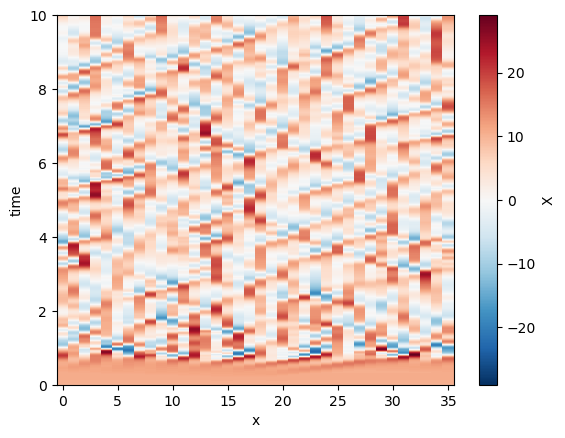

In [8]:
# initialisation
np.random.seed(42) # seed for reproducibility 

X_init = 10 * np.ones(36) #matrice des X et Y 
X_init[18] = 10 + 0.01 # sinon l96 tend vers 5 pour tous 

l96_two = L96TwoLevelOriginal(K=36, F=20, save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10
# spin-up 
l96_two.iterate(10) #10 MTUs
l96_two.history.X.plot()

We can see the spin-up period in red, 10 MTUs aren't necessary in this case, 2 would have been enough.
#### take the last state as an init for a new simulation
since now we are sure that it starts from the attractor

In [9]:
Newinit = l96_two.history.X[-1,:].values
Newinit

array([ 6.85930405,  0.85378527,  1.8144574 , 16.25982834,  3.76855251,
        3.46681175,  6.06471075, -5.81877386,  3.45983691, 16.56629724,
        3.39736532,  3.19765096,  6.72520676, -1.64242228, 13.8980829 ,
        4.55699548, -0.41684866,  0.41829977,  2.49956476,  1.44785262,
       -3.75293581,  9.22896302,  2.38889061,  6.25193716, 19.13267955,
        3.22150053,  0.16067503, -2.07323967, -0.14205577, -4.73308694,
       12.08177972, 18.68929989, -3.57590416, -1.29306775, -5.86777135,
       11.65815216])

  0%|          | 0/100000 [00:00<?, ?it/s]

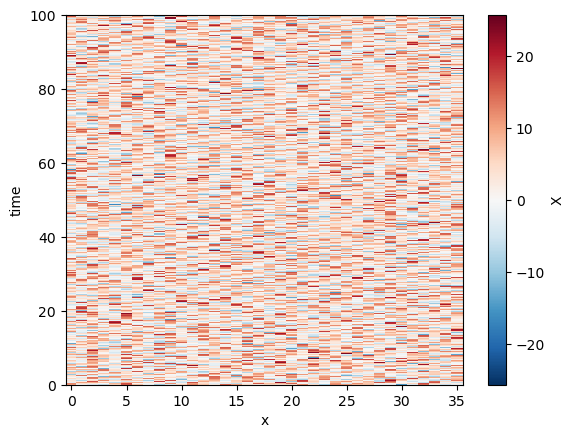

In [10]:
# run a longer simulation from the attractor for ground truth 
l96_two_truth = L96TwoLevelOriginal(K=36, F=20, save_dt=0.001, X_init=Newinit, integration_type='coupled')
l96_two_truth.iterate(100) #100 MTU
l96_two_truth.history.X.plot()

## 2. Short version

In [11]:
def init_ground_truth(x_init,F):
    L96_two = L96TwoLevelOriginal(K=36,  F=F,save_dt=0.001, X_init=X_init, integration_type='coupled')
    print('Spin-up')
    new_x_init = spin_up_for_init(L96_two,10)
    L96_two_truth = L96TwoLevelOriginal(K=36, F=F, save_dt=0.001, X_init=new_x_init, integration_type='coupled')
    print('Ground truth')
    L96_two_truth.iterate(100)
    return L96_two_truth
    

Spin-up


  0%|          | 0/10000 [00:00<?, ?it/s]

Ground truth


  0%|          | 0/100000 [00:00<?, ?it/s]

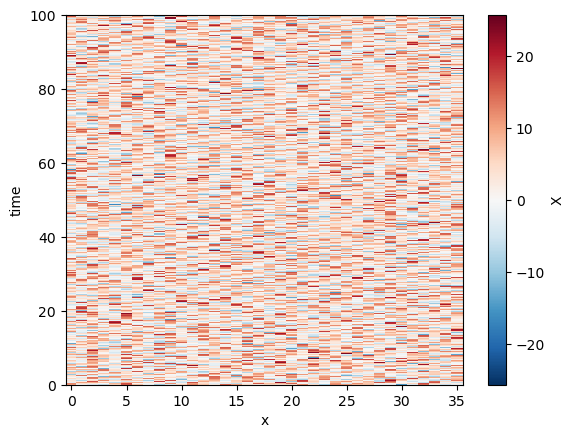

In [12]:
l96_two_truth = init_ground_truth(X_init,20)
l96_two_truth.history.X.plot()

# History Matching
We want to find the parameters (h, F, c, b)

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} - \underbrace{\frac{h c}{b} \Sigma_j Y_{j,k}}_{\text {Coupling}}$

$ \frac{d Y_{j, k}}{d t}=\underbrace{-b c Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{- c Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h c}{b} X_{k}}_{\text {Coupling }}$

## Metrics 
We will use the 5 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}(X, Y)=\left(\begin{array}{c}
X \\
\bar{Y} \\
X^{2} \\
X \bar{Y}\\
\bar{Y}^{2}
\end{array}\right)
$$

In [13]:
def metric(params):
    l96param = simulate(params) # we still perform the spin-up
    return l96param.mean_stats(ax=0)

## Wave 1

In [14]:
TrueTraj = l96_two_truth.mean_stats(ax=0) # mean_stats calcule les 5 metriques pour les 36 X
TrueTraj.shape

(180,)

Sanity check with the true params

In [15]:
sancheck = metric(np.array([1,20,10,10]))
np.mean((TrueTraj - sancheck)**2)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

0.0

Load and visualise the simulation points 

In [16]:
inputs_1 = pd.read_csv("../Data/df_inputs_newPCA_wave1.csv").values # valeurs après step 1 (4*10 training vectors, size 4, selected)
inputs_1.shape

(40, 4)

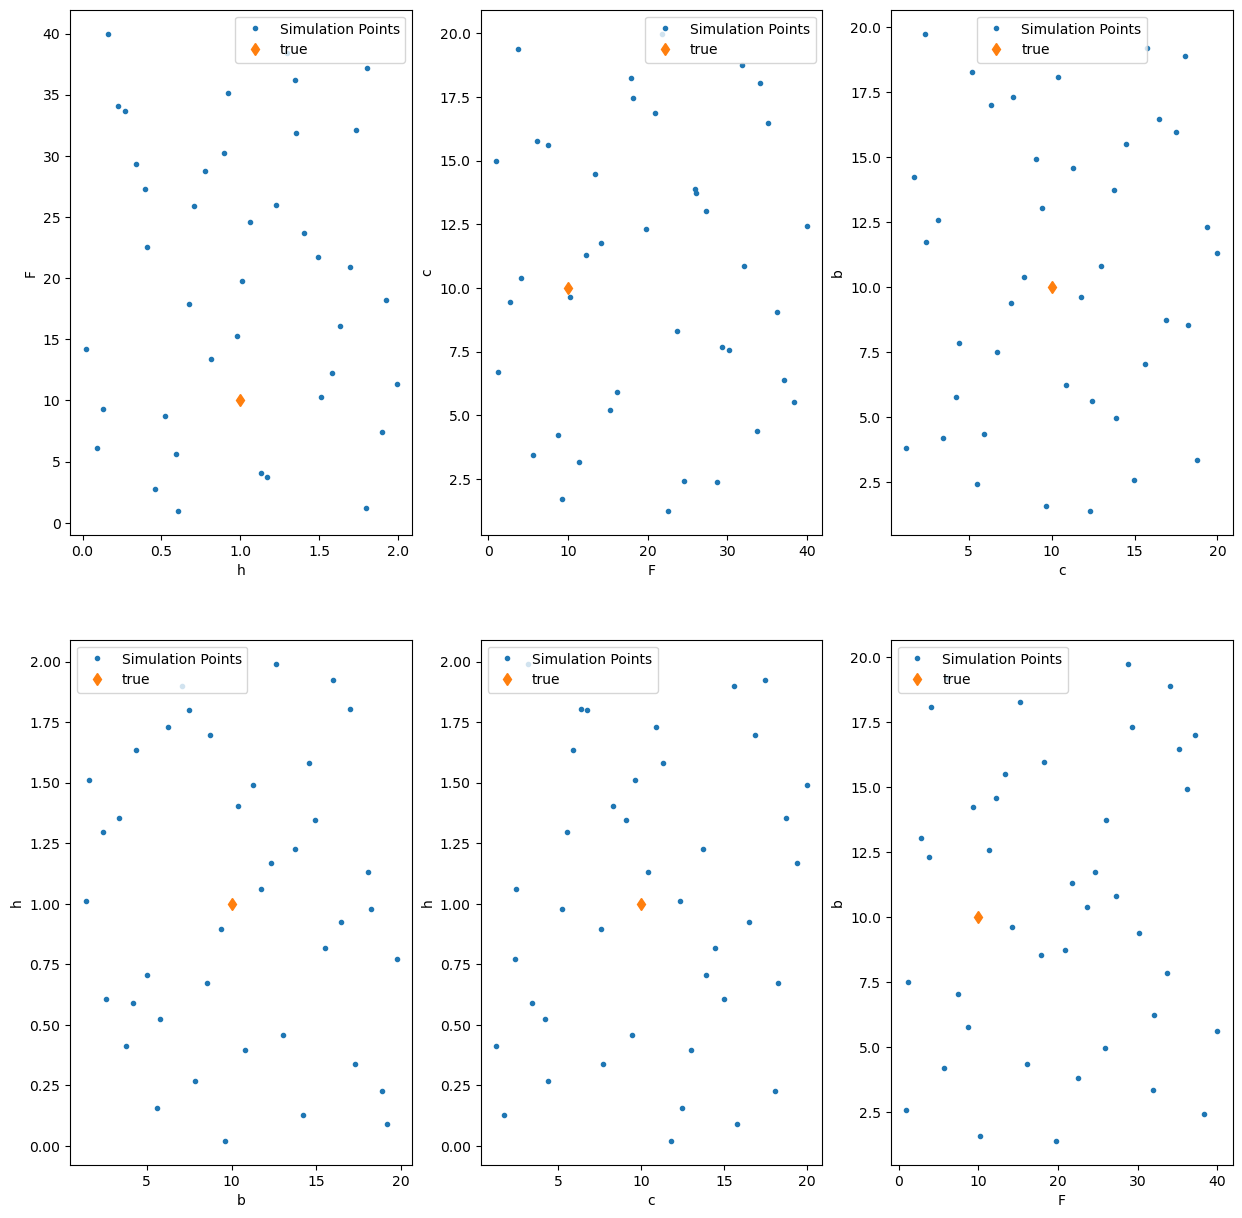

In [17]:
plot_simulation_points(inputs_1)

In [18]:
%%time
def wave_1(inputs, true_traj):
    #feel free to use a higher n_jobs if you can afford to
    results = Parallel(n_jobs=20)(delayed(metric)(i) for i in inputs) 
    targets = np.array(results)
    
    # ensure the simulations converged
    inputs = inputs[np.all(np.isfinite(targets), axis=1)]
    targets = targets[np.all(np.isfinite(targets), axis=1)]
    
    # PCA wave 1
    targetsreduced, SC, PC = reduceL96pca(targets)
    Obsreduced = reduceL96pca_usingwave1(true_traj[None,:], SC, PC)
    print('PCA reduced target shape', targetsreduced.shape)
    print('PCA reduced obs shape', Obsreduced.shape)
    
    plot_pc_1_2(targetsreduced, Obsreduced)
    plt.show()
    
    # save dataframe
    df_metrics = build_save_dataframe_metrics_to_csv(targetsreduced, 1)
    df_obs = build_save_dataframe_obs_to_csv(targetsreduced, Obsreduced, 1)
    print('Metrics')
    display(df_metrics)
    
    return Obsreduced, SC, PC

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


100%|██████████| 100000/100000 [00:43<00:00, 2319.56it/s]

PCA reduced target shape (40, 6)
PCA reduced obs shape (1, 6)


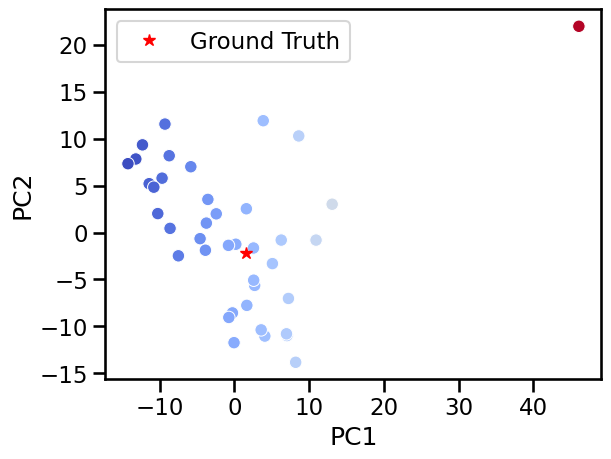

Metrics


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5
0,-3.561885,3.535879,-1.507407,0.694663,-1.108065,-0.306541
1,10.917396,-0.799558,-2.451949,1.121170,-3.907481,-0.373535
2,1.591128,2.541280,-2.770279,0.726805,-0.531844,0.131970
3,-12.315828,9.352241,4.220729,-0.403127,-0.610632,-0.071970
4,-3.763868,1.010209,-2.689839,-0.116717,0.064939,0.126202
5,7.221691,-7.021494,0.853203,-0.519785,-2.591470,-0.388332
6,7.027869,-10.979071,2.362256,-0.431110,-0.566230,0.094593
7,-13.207537,7.844066,3.366089,-2.044993,-0.913752,0.046125
8,4.060303,-11.032615,1.685962,0.117822,0.778398,0.037920
9,5.077265,-3.305892,-1.324280,-0.501554,-1.770681,0.515658


In [19]:
ObsReduced, SC, PC = wave_1(inputs_1, TrueTraj)

## Next waves 

In [20]:
def load_inputs_wave(nb_wave):
    inputs = pd.read_csv(f"../Data/exp_TuningL94_newPCA_wave{nb_wave}.csv").values
    return inputs 

In [21]:
def wave(nb_wave, sc, pc, obs_reduced):
    print(f'WAVE {nb_wave}')
    inputs_wave = load_inputs_wave(nb_wave)
    plot_simulation_points(inputs_wave)
    plt.show()
    
    #feel free to use a higher n_jobs if you can afford to
    results = Parallel(n_jobs=20)(delayed(metric)(i) for i in inputs_wave) 
    targets = np.array(results)
    
    # ensure the simulations converged
    inputs = inputs_wave[np.all(np.isfinite(targets), axis=1)]
    targets = targets[np.all(np.isfinite(targets), axis=1)]
    
    # PCA 
    targetsreduced = reduceL96pca_usingwave1(targets, sc, pc)
    print('PCA reduced target shape', targetsreduced.shape)
    
    print(f'PCA WAVE {nb_wave}')
    plot_pc_1_2(targetsreduced, obs_reduced)
    plt.show()
    
    # save dataframe
    df_metrics = build_save_dataframe_metrics_to_csv(targetsreduced, nb_wave)
    

## Run several waves 
First go to the HM notebook, before running the wave. 

WAVE 2


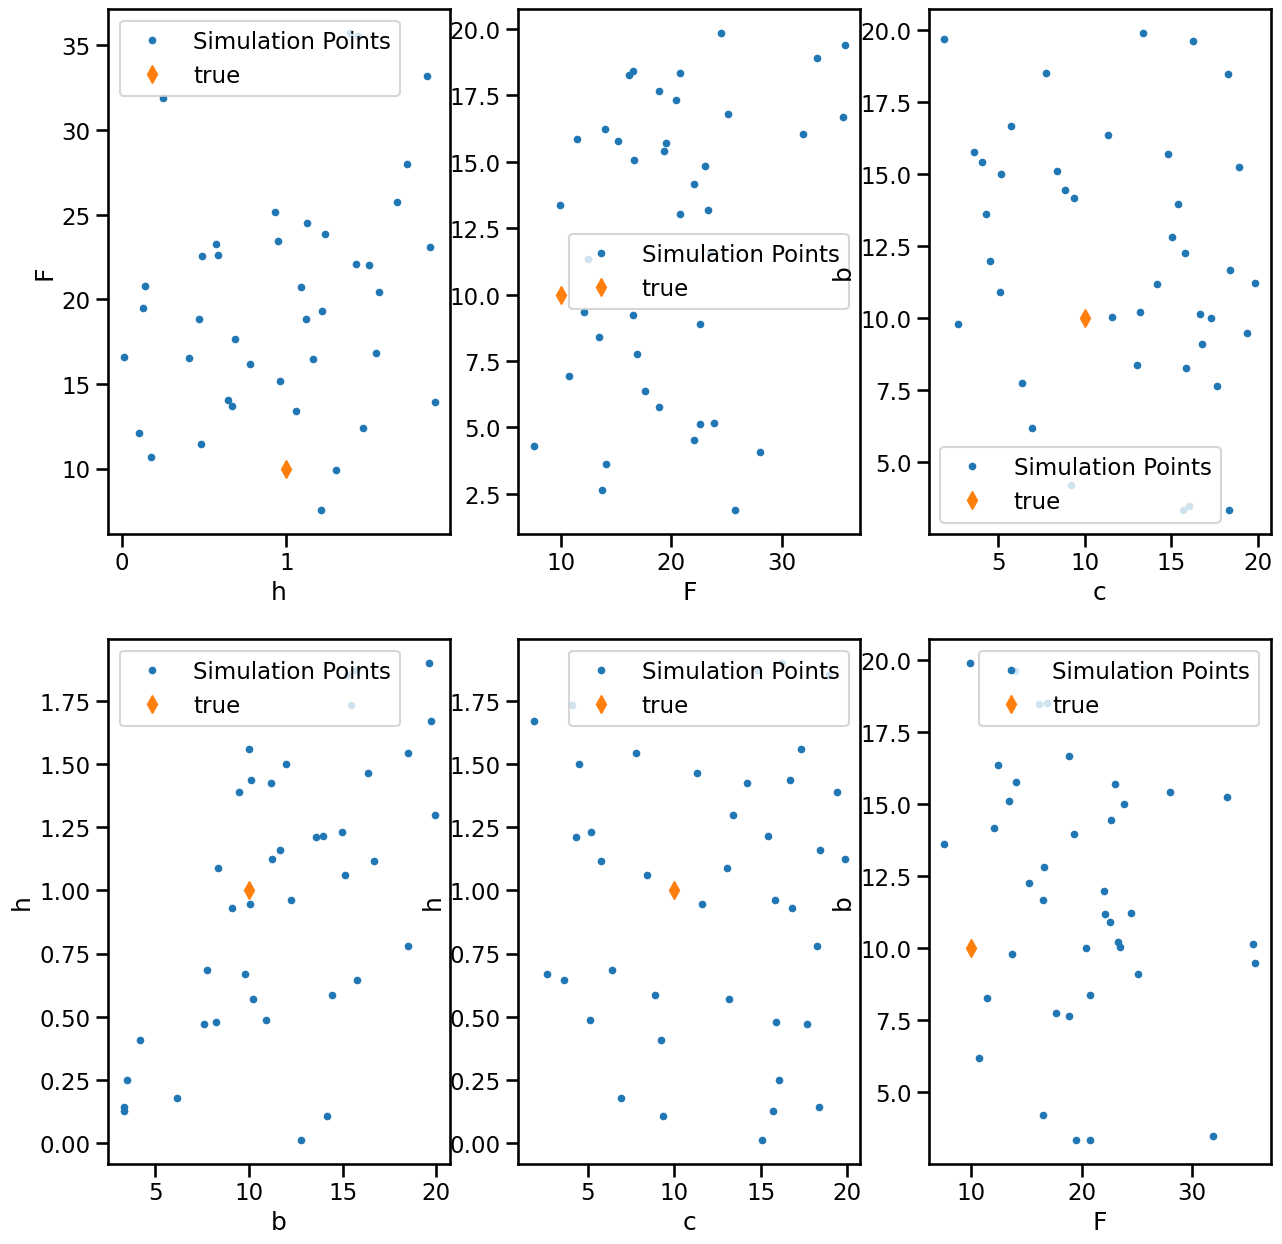





  0%|          | 0/10000 [00:00<?, ?it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 26%|██▌       | 2611/10000 [00:01<00:03, 2355.47it/s]

KeyboardInterrupt: 

In [22]:
wave(2,SC,PC,ObsReduced)

In [ ]:
wave(3,SC,PC,ObsReduced)

In [ ]:
wave(4,SC,PC,ObsReduced)

In [ ]:
wave(5,SC,PC,ObsReduced)

In [ ]:
wave(6,SC,PC,ObsReduced)

# Investigation of possible configurations

After steps 3 and 4, we perform a K-means as a low cost solution to find an ensemble of representative points from the final NROY (after wave 6 here).

We are left with possible configurations ('configs' variable). 

In [24]:
configs = pd.read_csv("../Data/finaltestpoints_newPCA.csv").values
configs.tolist()

[[0.999529732178608, 20.0344035692865, 9.91589489307814, 10.0741297816574],
 [1.12321866617146, 19.3212271711977, 7.32205846779455, 10.6133231007336],
 [1.02538257938436, 19.7302365938214, 10.2450397416976, 10.0833633044739],
 [1.15463312844506, 19.0369454434869, 7.06090549935846, 10.5031938458205],
 [0.930412690290427, 19.7733850136502, 9.2150352439788, 9.94071723963589],
 [1.05857269218618, 19.1707627199349, 8.82414405031876, 10.2795569909882]]

In [25]:
simus = [simulate(i) for i in configs.tolist()]
simus_metrics = [ii.mean_stats(ax=0) for ii in simus]
simus_metrics = np.array(simus_metrics)
simus_metrics.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

(6, 180)

In [26]:
simusreduced = reduceL96pca_usingwave1(simus_metrics, SC, PC)
simusreduced.shape

(6, 6)

In [40]:
simus_df = pd.DataFrame()

for i in range(simusreduced.shape[1]):
    simus_df['PC'+str(i+1)] = simusreduced[:,i]
    
#simus_df.to_csv('../Data/configs_metrics_newPCA.csv', index=False)

# add obs vector 
simus_df.loc[len(simus_df)]=list(ObsReduced[0,:])
simusdftranspose = simus_df.T
simusdftranspose.columns = [f'config{k+1}' for k in range(len(simus))] + ['Obs']
simusdftranspose

,config1,config2,config3,config4,config5,config6,Obs
PC1,1.819572,1.455449,1.595638,1.404691,1.475378,1.419634,1.585529
PC2,-2.376974,-2.054634,-2.081538,-1.798604,-2.419890,-2.017437,-2.132886
PC3,-1.917441,-1.738838,-2.026020,-1.713057,-1.822169,-1.893739,-1.903318
PC4,0.037559,-0.185749,0.022402,-0.137447,0.001250,0.008842,-0.045696
PC5,-1.155812,-1.211054,-0.988980,-1.229957,-1.090639,-1.155381,-1.169661
PC6,0.041368,-0.430965,-0.209776,0.370180,0.041576,0.279052,-0.171652


<AxesSubplot:>

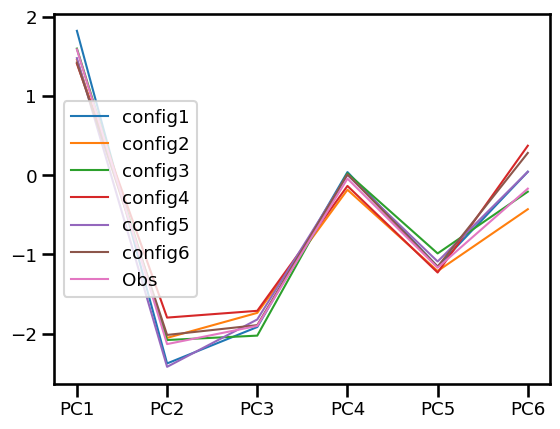

In [28]:
# on regarde les composantes principales des metriques obtenues 
sns.set_context("talk", font_scale=0.8, rc={"lines.linewidth": 1.5})

simusdftranspose.plot()

In [41]:
def plot_metric_density(simu, simudf):
    sns.set_style("white")
    sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 3})
    figure, axes = plt.subplots(2, 3, figsize=(25,10))
    
    nb_simu = len(simu) - 1
    # Obs
    simudf['Obs'].plot(linestyle="--", ax=axes[0,0])
    sns.kdeplot(l96_two_truth.history.X.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[0,1])
    sns.kdeplot((l96_two_truth.history.X**2).mean(axis=1), label='Obs', linestyle="--", ax=axes[1,0])
    sns.kdeplot((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1), label='Obs', linestyle="--", ax=axes[1,1])
    sns.kdeplot(l96_two_truth.history.Y_mean.mean(axis=1), label='Obs', linestyle="--", ax=axes[0,2])
    sns.kdeplot(l96_two_truth.history.Y2_mean.mean(axis=1), label='Obs', linestyle="--", ax=axes[1,2])
    
    for k in range(nb_simu):
        # PCA
        simudf[f'config{k+1}'].plot(ax=axes[0,0])
        # X
        sns.kdeplot(simu[k].history.X.mean(axis=1), label=f'config{k+1}', ax=axes[0,1])
        # Y 
        sns.kdeplot(simu[k].history.Y_mean.mean(axis=1), label=f'config{k+1}', ax=axes[0,2])
        # X**2
        sns.kdeplot((simu[k].history.X**2).mean(axis=1), label=f'config{k+1}', ax=axes[1,0])
        # XY
        sns.kdeplot((simu[k].history.X*simu[k].history.Y_mean).mean(axis=1), label=f'config{k+1}', ax=axes[1,1])
        # Y**2
        sns.kdeplot(simu[k].history.Y2_mean.mean(axis=1), label=f'config{k+1}', ax=axes[1,2])
        
    # labels 
    axes[0,2].set_xlabel(r'$\bar{Y}$')
    axes[1,0].set_xlabel(r'$X^2$')
    axes[1,2].set_xlabel(r'$\bar{Y^2}$')
    
    handles, labels = axes[1,2].get_legend_handles_labels()
    figure.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95),
          ncol=6, fancybox=True, shadow=False)
    
    plt.show() 

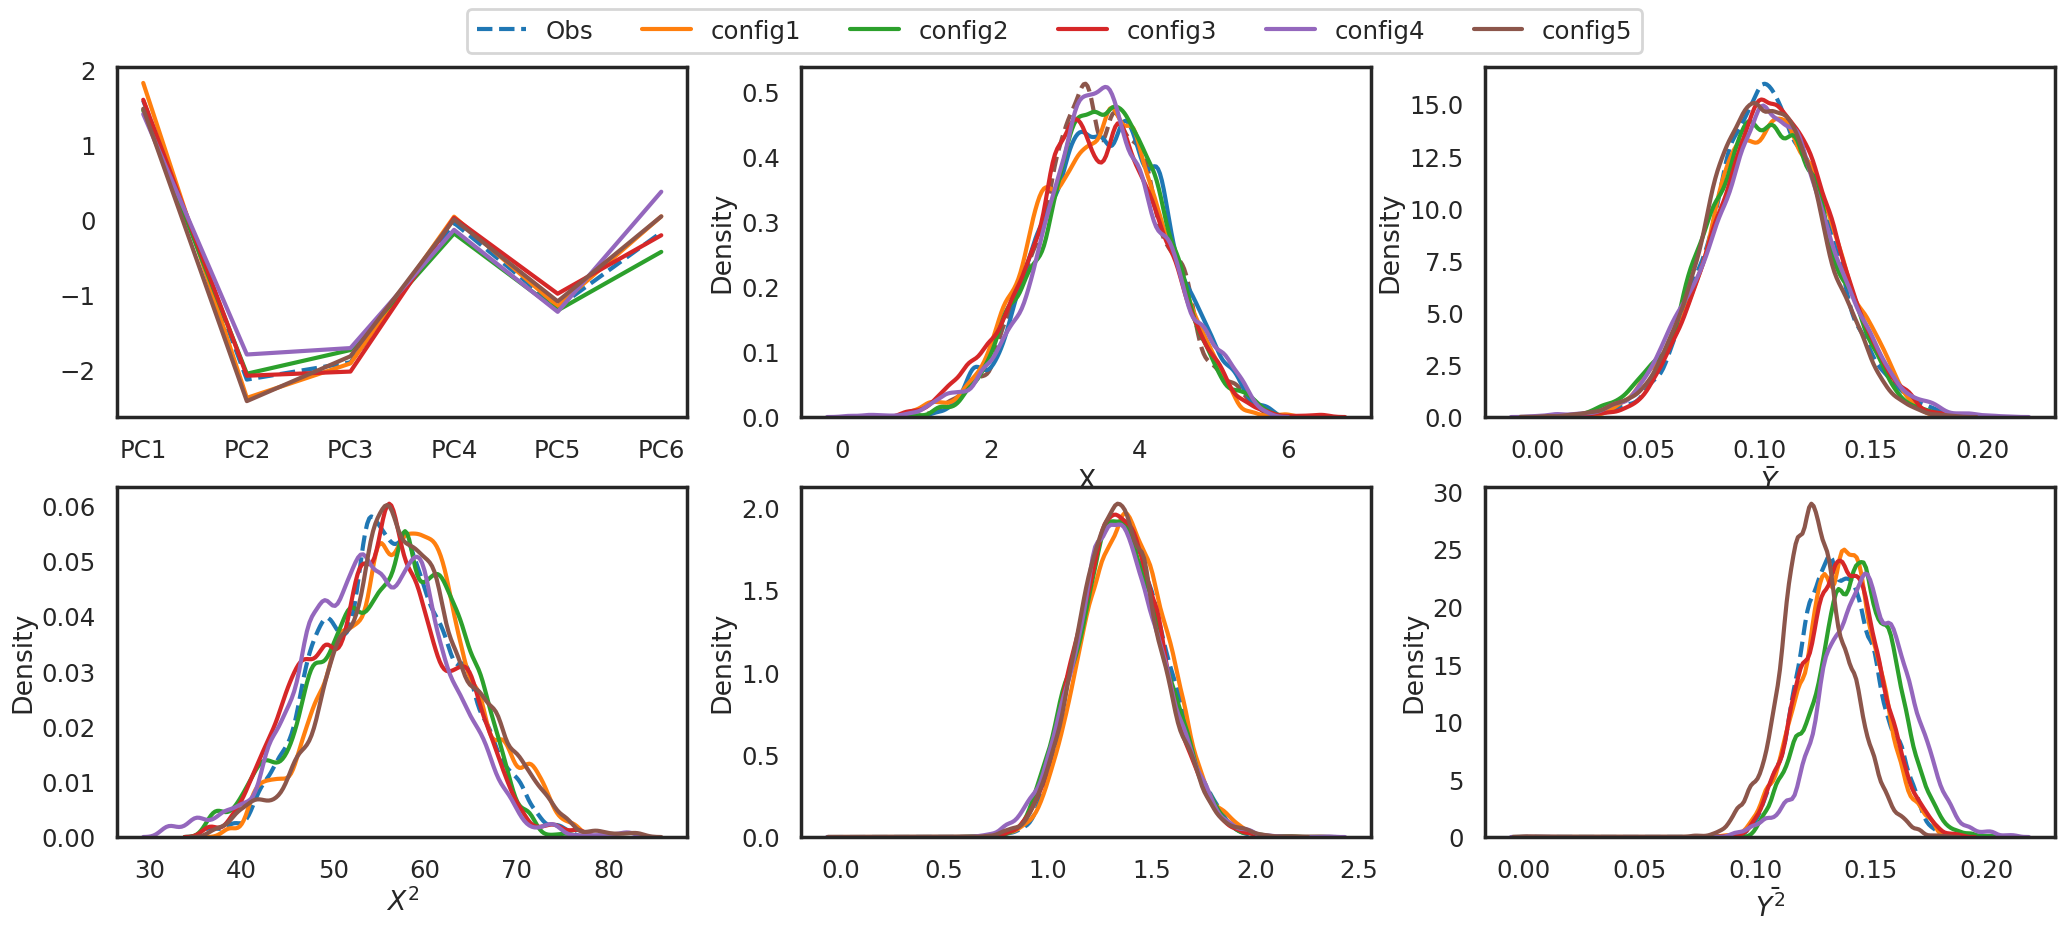

In [42]:
plot_metric_density(simus, simusdftranspose)

## KL divergence

In [ ]:
def KL_div_obs(sim):
    rangex=(l96_two_truth.history.X.mean(axis=1).min().values,
       l96_two_truth.history.X.mean(axis=1).max().values)
    rangeym=(l96_two_truth.history.Y_mean.mean(axis=1).min().values,
       l96_two_truth.history.Y_mean.mean(axis=1).max().values)
    rangexsq=((l96_two_truth.history.X**2).mean(axis=1).min().values,
       (l96_two_truth.history.X**2).mean(axis=1).max().values)
    rangexym=((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1).min().values,
       (l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1).max().values)
    rangeymsq=(l96_two_truth.history.Y2_mean.mean(axis=1).min().values,
       l96_two_truth.history.Y2_mean.mean(axis=1).max().values)
    return np.median([entropy(np.histogram(sim.history.X.mean(axis=1), range=rangex)[0],
                          np.histogram(l96_two_truth.history.X.mean(axis=1))[0]),
                  entropy(np.histogram(sim.history.Y_mean.mean(axis=1), range=rangeym)[0],
                          np.histogram(l96_two_truth.history.Y_mean.mean(axis=1))[0]),
                  entropy(np.histogram((sim.history.X**2).mean(axis=1), range=rangexsq)[0],
                          np.histogram((l96_two_truth.history.X**2).mean(axis=1))[0]),
                  entropy(np.histogram((sim.history.X*sim.history.Y_mean).mean(axis=1), range=rangexym)[0],
                          np.histogram((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1))[0]),
                  entropy(np.histogram(sim.history.Y2_mean.mean(axis=1), range=rangeymsq)[0],
                          np.histogram(l96_two_truth.history.Y2_mean.mean(axis=1))[0])])

In [ ]:
KL_div_obs(l96_two_truth)

In [ ]:
[KL_div_obs(sim) for sim in simus]

In [ ]:
configs